# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

from cleaning import clean_data,plot_attribute_distribution

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# Attributes:
AGER_TYP - Ager Typology  

AKT_DAT_KL - Act date KL

ALTER_HH - Hamburg Germany only (this is a huge city in the north of Germany where Bertelsmann/Arvato is located),

ALTER_KIND1 - age of child no. 1

ALTER_KIND2 - age of child no. 2

ALTER_KIND3 - age of child no. 3

ALTER_KIND4 - age of child no. 4

ALTERKATEGORIE_FEIN - age categories ('fein' in this case I guess means a more specific classification)

ANZ_KINDER - no. of children

ANZ_STATISTISCHE_HAUSHALTE - in Germany a census data is given about statistical households, here its number is counted

ARBEIT - work

D19_KONSUMTYP_MAX - what kind of consumption type you are

D19_LETZTER_KAUF_BRANCHE - the last date you bought something and in what category/segment

D19_VERSI_DATUM - insurance date

D19_VERSI_OFFLINE_DATUM - insurance date offline

D19_VERSI_ONLINE_DATUM - insurance date online

D19_VERSI_ONLINE_QUOTE_12 - insurance online in the last 12 month

DSL_FLAG - what kind of DSL are you using/ are you in (unfortunately some German regions are still IT medieval, not having a stable internet)

EINGEFUEGT_AM - inserted on

EINGEZOGEN_HH_JAHR - moved to household in year <yyyy>
    
FIRMENDICHTE - company density

KOMBIALTER - 'Kombi' means combination and 'Alter' is age

STRUKTURTYP - what kind of structural type you are

UMFELD_ALT - surrounding/neighbourhood is old

UMFELD_JUNG - surrounding/neighbourhood is young

VERDICHTUNGSRAUM - I guess they mean the urban agglomeration

VERS_TYP - what kind of insurance type you are

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
customers.columnsumns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=369)

In [4]:
pd.set_option('display.max_columns',None)

In [5]:
pd.set_option('display.max_rows',None)

In [3]:
# Shape and head of general data
print("General population shape {}.".format(azdias.shape))
azdias.head()

General population shape (891221, 366).


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [8]:
# Shape and head of customers data
print("Customers shape {}.".format(customers.shape))
customers.head()

Customers shape (191652, 369).


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [9]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [3]:
#droping columns that have different colum names form Customer dataset 
customers=customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 
       'ALTERSKATEGORIE_GROB','PRODUCT_GROUP'],axis=1)

In [11]:
# Concat Two columns for plotting
azdias['dataset'] = 'Azdias'
customers['dataset'] = 'Customers'
combine_df = pd.concat([azdias, customers])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


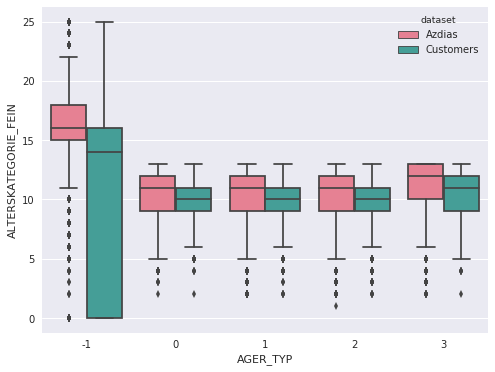

In [16]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
sns.boxplot(x="AGER_TYP", y="ALTERSKATEGORIE_FEIN",dodge=True,hue="dataset",data=combine_df,palette="husl");

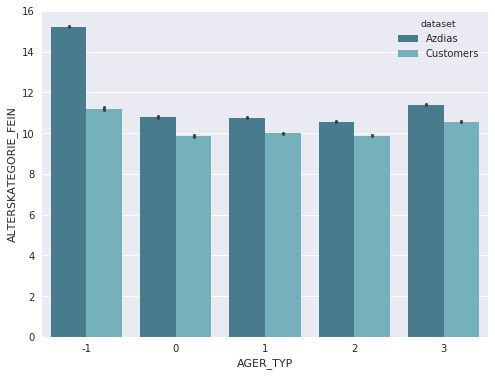

In [21]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
sns.barplot(x="AGER_TYP", y="ALTERSKATEGORIE_FEIN", hue="dataset",data=combine_df,palette='GnBu_d')

### Missing values 

In [3]:
#number of missing values by each column in azdias dataset
col_nul_percent=azdias.isnull().sum()/azdias.shape[0]

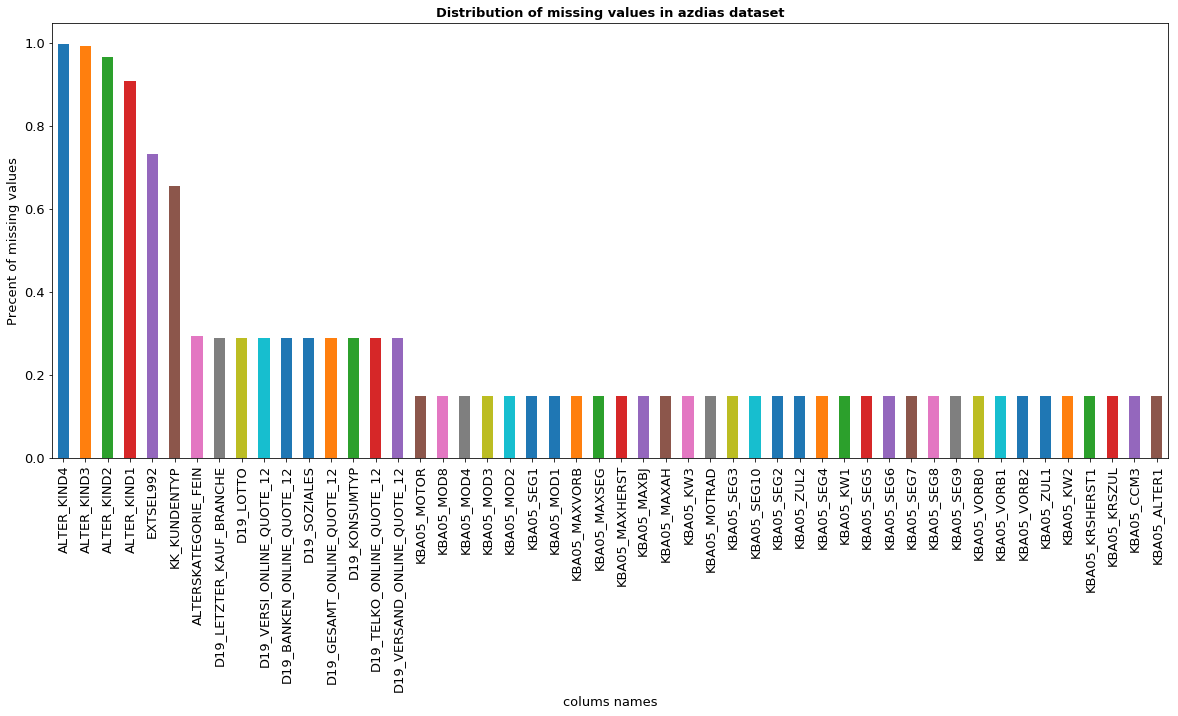

In [4]:
plt.title("Distribution of missing values in azdias dataset",fontsize=13,fontweight="bold")
plt.xlabel("colums names",fontsize=13)
plt.ylabel("Precent of missing values",fontsize=13)
(col_nul_percent.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13));

In [3]:
#Distribution of missing values by columns:-
missing_by_col=azdias.isnull().sum()/azdias.shape[0]  

Text(0,0.5,'count')

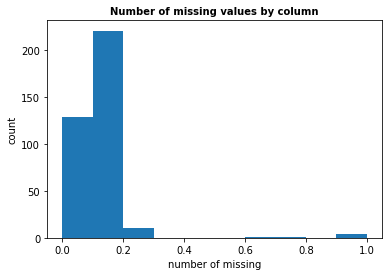

In [5]:
plt.hist(missing_by_col)
plt.title("Number of missing values by column",fontsize=10,fontweight="bold")
plt.xlabel("number of missing",fontsize=10)
plt.ylabel("count",fontsize=10)

In [10]:
#Distribution of missing values by rows:-
row_nul_percent=azdias.isnull().sum(axis=1)  

Text(0,0.5,'count')

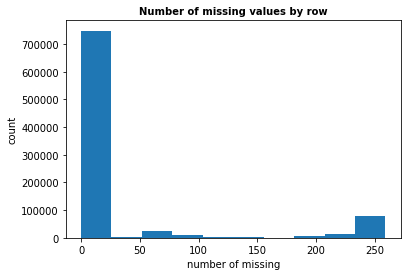

In [20]:
plt.hist(row_nul_percent)
plt.title("Number of missing values by row",fontsize=10,fontweight="bold")
plt.xlabel("number of missing",fontsize=10)
plt.ylabel("count",fontsize=10)

In [22]:
#droping columns that have more than 20% of missing values
column_nans = azdias.isnull().mean()
drop_cols = azdias.columns[column_nans > 0.20]
print('columns to drop: ', drop_cols)


columns to drop:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'],
      dtype='object')


In [26]:
#droping columns that are start with KBA05
kba_cols = azdias.columns[azdias.columns.str.startswith('KBA05')]
kba_cols

Index(['KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4',
       'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1',
       'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU',
       'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3',
       'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT',
       'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
       'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL',
       'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ',
       'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1',
       'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MODTEMP',
       'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10',
       'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6',
       'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VO

In [6]:
#selecting categorical columns for feature engineering
azdias.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

## Data Preprocessing

#### Start cleaning the azdias dataset

In [4]:
cleaned_azdias = clean_data(azdias)

Drop columns with more than 20% of missing values and Droping unnecessary columns that doesn't have description in   Attribute Info file
droping column EINGEFUEGT_AM and D19_LETZTER_KAUF_BRANCHE because it contain too many different items
droping ID column from dataset
creating a copy of dataframe
Remove rows with less than 25 missing attributes
Re-encode OST_WEST_KZ attribute
Feature Engineer PRAEGENDE_JUGENDJAHRE
Feature Engineer WOHNLAGE
Feature Engineer PLZ8_BAUMAX
Feature extracting CAMEO_DEUG_2015
remove columns with start with kba
Imputing Nan values
Counting Nan values 0


In [5]:
cleaned_azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ALTERSKATEGORIE_GROB,MOVEMENT,GENERATION_DECADE,RURAL_NEIGHBORHOOD,PLZ8_BAUMAX_BUSINESS,PLZ8_BAUMAX_FAMILY
1,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,11.0,3.0,9.0,5.0,1.0,1.0,9.0,0.0,0.0,1.0
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,9.0,3.0,9.0,5.0,3.0,2.0,9.0,0.0,0.0,1.0
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,10.0,4.0,9.0,3.0,4.0,1.0,7.0,1.0,0.0,1.0
4,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,5.0,2.0,9.0,4.0,3.0,1.0,7.0,0.0,0.0,2.0
5,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,7.0,6.0,9.0,4.0,1.0,1.0,5.0,1.0,0.0,1.0


In [32]:
cleaned_azdias.shape

(751042, 252)

In [6]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

In [7]:
cleaned_azdias[cleaned_azdias.columns] = scaler.fit_transform(cleaned_azdias)

In [8]:
cleaned_azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ALTERSKATEGORIE_GROB,MOVEMENT,GENERATION_DECADE,RURAL_NEIGHBORHOOD,PLZ8_BAUMAX_BUSINESS,PLZ8_BAUMAX_FAMILY
1,1.249253,1.625570,0.158851,-0.128371,-0.296855,0.233387,0.292060,-0.060632,-0.185398,0.852118,...,1.057497,-0.569687,0.548508,1.138608,-1.684743,-0.530918,1.181192,-0.546555,-0.383077,-0.312999
2,1.249253,0.732986,0.095017,-0.128371,-0.296855,-0.626814,-0.055113,-0.060632,-0.185398,-0.975097,...,0.442723,-0.569687,0.548508,1.138608,0.164105,1.883531,1.181192,-0.546555,-0.383077,-0.312999
3,-0.942576,-0.159597,-0.479484,-0.128371,-0.296855,-1.487015,-0.402287,-0.060632,-1.191880,-0.061490,...,0.750110,-0.030352,0.548508,-0.285393,1.088529,-0.530918,-0.208306,1.829642,-0.383077,-0.312999
4,-0.942576,0.063548,-0.351817,-0.128371,-0.296855,1.953789,-0.332852,-0.060632,0.821084,-0.975097,...,-0.786826,-1.109023,0.548508,0.426608,0.164105,-0.530918,-0.208306,-0.546555,-0.383077,0.660468
5,-0.942576,-0.829035,-0.224150,-0.128371,-0.296855,-0.626814,-0.402287,-0.060632,-1.191880,0.852118,...,-0.172052,1.048319,0.548508,0.426608,-1.684743,-0.530918,-1.597803,1.829642,-0.383077,-0.312999


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Apply PCA to the data.

In [36]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

CPU times: user 3min 17s, sys: 7.51 s, total: 3min 25s
Wall time: 5min 19s


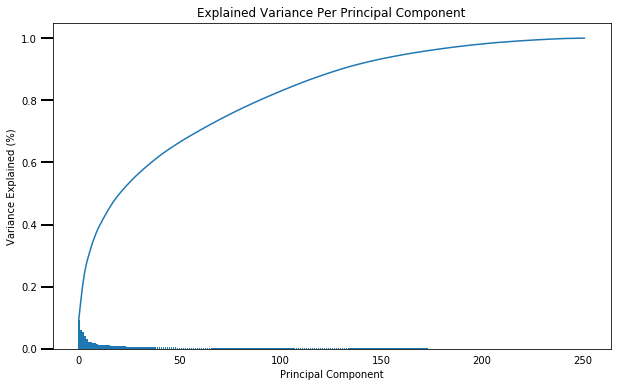

In [37]:
%%time
pca = PCA()
azdias_pca = pca.fit_transform(cleaned_azdias)
scree_plot(pca)

In [14]:
explained_var_ratio = sum(pca.explained_variance_ratio_)
print("Explained variance ratio:", explained_var_ratio.round(2)*100)

Explained variance ratio: 100.0


CPU times: user 3min 27s, sys: 52.5 s, total: 4min 19s
Wall time: 14min 39s


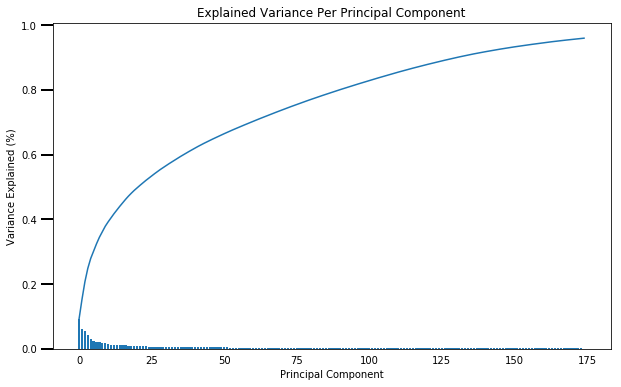

In [38]:
%%time
#Apply 175 componets to PCA
pca = PCA(175)
azdias_pca = pca.fit_transform(cleaned_azdias)
scree_plot(pca)

In [39]:
explained_var_ratio = sum(pca.explained_variance_ratio_)
print("Explained variance ratio:", explained_var_ratio.round(2)*100)

Explained variance ratio: 96.0


### PCA Interpretation

In [53]:
# Map weights for the principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def print_interesting_features(features, components, i):
    feature_weights = dict(zip(features, components[i]))
    feature_weights_sorted = sorted(feature_weights.items(), key=lambda kv: kv[1])
    print('Lowest:')
    for feature, weight in feature_weights_sorted[:5]:
        print('\t{:20} {:.3f}'.format(feature, weight))
        
    print('Highest:')
    for feature, weight in feature_weights_sorted[-5:]:
        print('\t{:20} {:.3f}'.format(feature, weight))

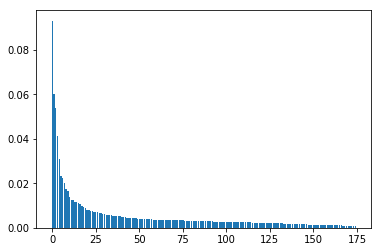

In [41]:
# Investigate the variance accounted for by each principal component.
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
plt.bar(ind, vals)
plt.show()

In [54]:
# First principal component
i = 0
print('{:5.2%}'.format(vals[i]))
print("PCA 1")
print_interesting_features(cleaned_azdias.columns.values, pca.components_, i)

9.30%
PCA 1
Lowest:
	PLZ8_ANTG1           -0.163
	KBA13_ANTG1          -0.162
	MOBI_REGIO           -0.154
	KBA13_AUTOQUOTE      -0.151
	MOBI_RASTER          -0.146
Highest:
	PLZ8_ANTG4           0.156
	KBA13_BAUMAX         0.157
	KBA13_ANTG4          0.158
	KBA13_ANTG3          0.162
	PLZ8_ANTG3           0.163


### PCA 1 most important features with positive weights and negative weights:

Lowest:

- The most prominent negative features are MOBI_RASTER, KBA13_AUTOQUOTE and KBA13_ANTG1.

- KBA13_AUTOQUOTE is a share of cars per household within the PLZ8 (5 = very high)

- MOBI_REGIO is estimated moving patterns (1 = very high mobility)

- PLZ8_ANTG1 is estimate a number of 1-2 family houses in the PLZ8 (4 = very high share)  


Highest:

- PLZ8_ANTG3 is estimate a number of 6-10 family houses in the PLZ8 (3 = very high share)	

- The most prominent positive features are KBA13_ANTG3, KBA13_ANTG4 and KBA13_BAUMAX

- PLZ8_ANTG4 is estimate a number of >10 family houses in the PLZ8 (2 = high share)


#### So, PCA 1 is associated with person's moving patterns and  have family houses shares, also have share of cars per household. 


In [55]:
# Second principal component
i = 1
print('{:5.2%}'.format(vals[i]))
print("PCA 2")
print_interesting_features(cleaned_azdias.columns.values, pca.components_, i)

6.00%
PCA 2
Lowest:
	KBA13_SITZE_5        -0.170
	KBA13_KMH_140_210    -0.152
	KBA13_SEG_KLEINWAGEN -0.151
	KBA13_KMH_180        -0.144
	KBA13_HALTER_25      -0.139
Highest:
	KBA13_SITZE_4        0.162
	KBA13_BMW            0.172
	KBA13_SEG_OBEREMITTELKLASSE 0.176
	KBA13_MERCEDES       0.178
	KBA13_HERST_BMW_BENZ 0.206


### PCA 2 most important features with positive weights and negative weights:

Lowest:

- KBA13_HALTER_25 is a share of car owners below 21 within the PLZ8 (5 = very high)

- KBA13_KMH_180 is a share of cars with max speed between 110 km/h and 180km/h within the PLZ8

- KBA13_SEG_KLEINWAGEN is a share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8

- KBA13_KMH_140_210 is a share of cars with max speed between 210 and 250 km/h within the PLZ8

- KBA13_SITZE_5 is a number of cars with 5 seats in the PLZ8 (5 = very high)   



Highest:

- KBA13_HERST_BMW_BENZ is a share of BMW & Mercedes Benz within the PLZ8 (5 = very high share)

- KBA13_MERCEDES is a share of MERCEDES within the PLZ8. (5 = very high share)

- KBA13_SEG_OBEREMITTELKLASSE is a share of upper class cars (BMW 7er etc.) in the PLZ8

- KBA13_BMW is a share of BMW within the PLZ8 (5 = very high)

- KBA13_SITZE_4 is a number of cars with less than 5 seats in the PLZ8 (5 = very high)


#### So, PCA 2 is associated with number of cars, numbers of shares of small and upper class cars.
Higher component relates to higher probability of people have shares of upper class cars(i.e BMW, MERCEDES).
So, people who are financially stable are likey to become mail-order company's customer. 

In [56]:
# Third principal component
i = 2
print('{:5.2%}'.format(vals[i]))
print("PCA 3")
print_interesting_features(cleaned_azdias.columns.values, pca.components_, i)


5.40%
PCA 3
Lowest:
	CJT_TYP_5            -0.197
	FINANZ_VORSORGER     -0.195
	ALTERSKATEGORIE_GROB -0.192
	CJT_TYP_4            -0.192
	CJT_TYP_3            -0.184
Highest:
	FINANZ_UNAUFFAELLIGER 0.180
	ONLINE_AFFINITAET    0.182
	FINANZ_SPARER        0.206
	CJT_TYP_1            0.206
	GENERATION_DECADE    0.224


### PCA 3 most important features with positive weights and negative weights:

Lowest:

- ALTERSKATEGORIE_GROB is estimate a age classification.

- FINANZ_VORSORGER is financial typology: be prepared (1 = very high)

- The most prominent negative features are CJT_TYP_5 ,CJT_TYP_4 and CJT_TYP_3


Highest:

- FINANZ_SPARER is estimate financial typology interms of money saver (1 = very high)

- ONLINE_AFFINITAET is online affinity. (5 = very high)

- FINANZ_UNAUFFAELLIGER is financial typology: unremarkable (1 = very high)
    
- The most prominent positive features are GENERATION_DECADE and CJT_TYP_1




#### So, PCA 3 is associated with person's age, financial typology and online affinity. 
Higher component relates to higher probability of people being older in age, money savers and online affinity(online connected to firm.) are likely to become mail-order company's customer.


### Clustering

In [50]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

CPU times: user 2min 49s, sys: 0 ns, total: 2min 49s
Wall time: 2min 50s


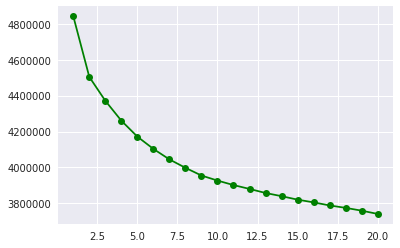

In [94]:
%%time
scores = []
for i in range(1, 21):
    scores.append(score(azdias_pca[:20000], i))
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='o', color='green')

Text(0.5,0,'Number of Clusters')

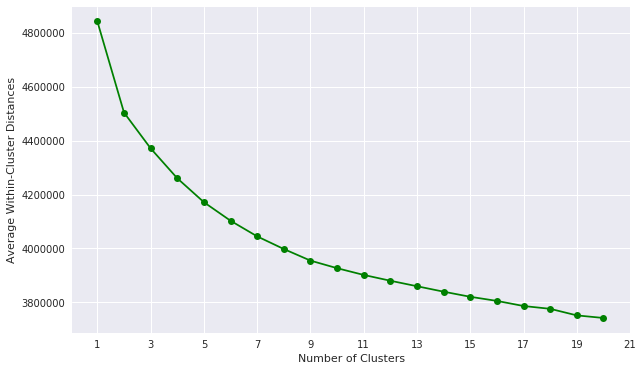

In [93]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(10,6))
plt.plot(centers, scores, linestyle='-', marker='o', color='green')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

To identify an ideal number of clusters the Elbow plot was created for the number of clusters from 1 to 30. 
The average within-cluster distances plotted against number of components demonstrates that
the score was rapidly decreased for the first 16 components and continue to decrease for higher number of clusters
but with lower slope. So, 16 clusters were selected.

In [9]:
n_components = 175
n_clusters = 16
cluster_pipeline = Pipeline([
                        ('pca', PCA(n_components)),
                        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42) )
                        ])

In [10]:
cluster_pipeline.fit(cleaned_azdias)
prediction_azdias=cluster_pipeline.predict(cleaned_azdias)
prediction_azdias[:20]

array([ 2,  2,  1, 10, 12,  2,  2,  8,  8,  5,  2,  2,  8, 13, 13,  2, 10,
        2, 14,  0], dtype=int32)

In [19]:
df_prediction_azdias = pd.DataFrame(prediction_azdias, columns = ['Cluster'])
df_prediction_azdias.head(5)

,Cluster
0,2
1,2
2,1
3,10
4,12


In [20]:
customers.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,0.0,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1


In [21]:
print("Customers Data: Cleaning \n")
cleaned_customers = clean_data(customers)

Customers Data: Cleaning 

Drop columns with more than 20% of missing values and Droping unnecessary columns that doesn't have description in   Attribute Info file
droping column EINGEFUEGT_AM and D19_LETZTER_KAUF_BRANCHE because it contain too many different items
droping ID column from dataset
creating a copy of dataframe
Remove rows with less than 25 missing attributes
Re-encode OST_WEST_KZ attribute
Feature Engineer PRAEGENDE_JUGENDJAHRE
Feature Engineer WOHNLAGE
Feature Engineer PLZ8_BAUMAX
Feature extracting CAMEO_DEUG_2015
remove columns with start with kba
Imputing Nan values
Counting Nan values 0


In [22]:
print("Scaling the Data \n")
scaler = StandardScaler()
cleaned_customers[cleaned_customers.columns] = scaler.fit_transform(cleaned_customers) 

Scaling the Data 



In [24]:
print("Customers Data: Cluster Predictions \n")
cluster_pipeline.fit(cleaned_customers)
customers_predictions = cluster_pipeline.predict(cleaned_customers)
customers_predictions[:20]

Customers Data: Cluster Predictions 



array([10, 11, 10,  0,  5, 10, 15,  9,  7, 13, 13,  9, 10,  7,  0, 12, 11,
        3,  4,  9], dtype=int32)

In [25]:
df_prediction_customers = pd.DataFrame(customers_predictions, columns = ['Cluster'])
df_prediction_customers.head(5)

,Cluster
0,10
1,11
2,10
3,0
4,5


In [26]:
#create a copy of general poplulation dataframe
general_predictions=df_prediction_azdias.copy()

In [27]:
'''

Compare the proportion of data in each cluster for the customer data to 
the proportion of data in each cluster for the general population.

'''

dfbar = pd.DataFrame(columns=['clusters','type'])
dfbar['clusters'] = np.append(general_predictions, customers_predictions)
dfbar['type'] = ['general']*len(general_predictions) + ['customers']*len(customers_predictions)

general_counts = np.array(dfbar['clusters'].loc[dfbar['type'] == 'general'].value_counts().
                          sort_index(ascending=True))
customers_counts = np.array(dfbar['clusters'].loc[dfbar['type'] == 'customers'].value_counts().
                            sort_index(ascending=True))

print("General counts: {}".format(general_counts))
print("Customers counts: {}".format(customers_counts))

general_ratio = general_counts/len(general_predictions)
customers_ratio = customers_counts/len(customers_predictions)
print("General ratio: {}".format(general_ratio.round(2)))
print("Customers ratio: {}".format(customers_ratio.round(2)))

General counts: [43710 65767 71143 26154 29176 61524 43388 51153 38197 16563 46140 35514
 72402 53471 63601 33139]
Customers counts: [ 8802  8481  4444 11719 10258 10226 11705 11475   295  6383 11852 11607
  4497  9608   172 13506]
General ratio: [ 0.06  0.09  0.09  0.03  0.04  0.08  0.06  0.07  0.05  0.02  0.06  0.05
  0.1   0.07  0.08  0.04]
Customers ratio: [ 0.07  0.06  0.03  0.09  0.08  0.08  0.09  0.08  0.    0.05  0.09  0.09
  0.03  0.07  0.    0.1 ]


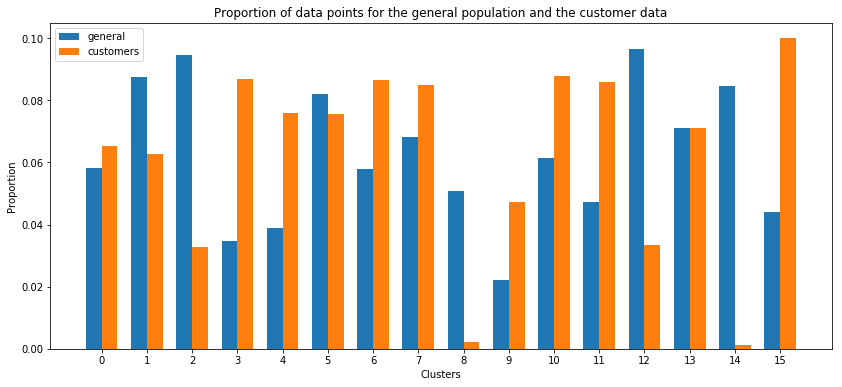

In [29]:
index = np.arange(n_clusters)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(14,6))

#print(len(customers_ratio))
ax.bar(index, general_ratio, bar_width, label = "general")
ax.bar(index+bar_width, customers_ratio, bar_width, label = "customers")

ax.set_xlabel('Clusters')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of data points for the general population and the customer data')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()

#fig.tight_layout()
plt.show()

We noticed that people with following characteristics is more likely to be customers for mail oder

1. Moving possibility is low
2. Hold more shares and higher professional titles
3. Higher transaction activities and total online/transaction activities
4. Older in age
5. Money savers